<a href="https://colab.research.google.com/github/nazaninbondarian/MachineLearning2024/blob/main/Chapter%203/Question%201/Q1_D.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [25]:
# Import necessary libraries
from sklearn import datasets
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis as LDA
import cvxopt
from sklearn.svm import SVC
from sklearn.preprocessing import LabelEncoder
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix, precision_score, recall_score, f1_score
import seaborn as sns
import os
import imageio


In [26]:
!pip install numpy matplotlib scikit-learn imageio

In [27]:
# Load the Iris dataset
iris = datasets.load_iris()
X = iris.data
y = iris.target
feature_names = iris.feature_names

# Convert to DataFrame for easier manipulation
df = pd.DataFrame(X, columns=feature_names)
df['species'] = y

In [28]:
# Split the dataset into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=76)
X_train.shape, y_train.shape, X_test.shape, y_test.shape

((120, 4), (120,), (30, 4), (30,))

In [29]:
lda = LDA(n_components=2)
X_train_lda = lda.fit_transform(X_train, y_train)
X_test_lda= lda.transform(X_test)

In [43]:
def linear_kernel( x1, x2):
    return np.dot(x1, x2)

def polynomial_kernel( x, y, C=1.0, d=3):
    return (np.dot(x, y) + C) ** d

def gaussian_kernel( x, y, gamma=0.5):
    return np.exp(-gamma*np.linalg.norm(x - y) ** 2)

def sigmoid_kernel( x, y, alpha=1, C=0.01):
    a= alpha * np.dot(x, y) + C
    return np.tanh(a)

def SVM1(X, X_t, y, C, kernel_type, poly_params=(1, 4), RBF_params=0.5, sigmoid_params=(1, 0.01)):
    kernel_and_params = (kernel_type, poly_params, RBF_params, sigmoid_params, C)
    n_samples, n_features = X.shape
    # Compute the Gram matrix
    K = np.zeros((n_samples, n_samples))
    if kernel_type == 'linear':
        for i in range(n_samples):
            for j in range(n_samples):
                K[i, j] = linear_kernel(X[i], X[j])
    elif kernel_type == 'polynomial':
        for i in range(n_samples):
            for j in range(n_samples):
                K[i, j] = polynomial_kernel(X[i], X[j], poly_params[0], poly_params[1])
    elif kernel_type == 'RBF':
        for i in range(n_samples):
            for j in range(n_samples):
                K[i, j] = gaussian_kernel(X[i], X[j], RBF_params)
    elif kernel_type == 'sigmoid':
        for i in range(n_samples):
            for j in range(n_samples):
                K[i, j] = sigmoid_kernel(X[i], X[j], sigmoid_params[0], sigmoid_params[1])
    else:
        raise ValueError("Invalid kernel type")

    # construct P, q, A, b, G, h matrices for CVXOPT
    P = cvxopt.matrix(np.outer(y, y) * K)
    q = cvxopt.matrix(np.ones(n_samples) * -1)
    A = cvxopt.matrix(y, (1, n_samples))
    b = cvxopt.matrix(0.0)
    G = cvxopt.matrix(np.vstack((np.diag(np.ones(n_samples) * -1), np.identity(n_samples))))
    h = cvxopt.matrix(np.hstack((np.zeros(n_samples), np.ones(n_samples) * C)))
    # solve QP problem
    cvxopt.solvers.options['show_progress'] = False
    solution = cvxopt.solvers.qp(P, q, G, h, A, b)
    # Lagrange multipliers
    a = np.ravel(solution['x'])
    # Support vectors have non-zero Lagrange multipliers
    sv = a > 1e-5  # some small threshold

    # Support vectors have non-zero Lagrange multipliers
    ind = np.arange(len(a))[sv]
    a = a[sv]
    sv_x = X[sv]
    sv_y = y[sv]
    numbers_of_sv = len(sv_y)

    # Bias (For linear it is the intercept):
    bias = 0
    if len(a) > 0:
        for n in range(len(a)):
            # For all support vectors:
            bias += sv_y[n]
            bias -= np.sum(a * sv_y * K[ind[n], sv])
        bias = bias / len(a)
    else:
        print("No support vectors found")
        bias = 0

    # Weight vector
    if kernel_type == 'linear':
        w = np.zeros(n_features)
        for n in range(len(a)):
            w += a[n] * sv_y[n] * sv_x[n]
    else:
        w = None

    y_pred = 0
    # Create the decision boundary for the plots. Calculates the hypothesis.
    if w is not None:
        y_pred = np.sign(np.dot(X_t, w) + bias)
    else:
        y_predict = np.zeros(len(X_t))
        for i in range(len(X_t)):
            s = 0
            for a1, sv_y1, sv1 in zip(a, sv_y, sv_x):
                # a : Lagrange multipliers, sv : support vectors.
                # Hypothesis: sign(sum^S a * y * kernel + b)
                if kernel_type == 'linear':
                    s += a1 * sv_y1 * linear_kernel(X_t[i], sv1)
                if kernel_type == 'RBF':
                    s += a1 * sv_y1 * gaussian_kernel(X_t[i], sv1, RBF_params)   # Kernel trick.
                if kernel_type == 'polynomial':
                    s += a1 * sv_y1 * polynomial_kernel(X_t[i], sv1, poly_params[0], poly_params[1])
                if kernel_type == 'sigmoid':
                    s += a1 * sv_y1 * sigmoid_kernel(X_t[i], sv1, sigmoid_params[0], sigmoid_params[1])
            y_predict[i] = s
        y_pred = np.sign(y_predict + bias)

    return w, bias, solution, a, sv_x, sv_y, y_pred, kernel_and_params

def multiclass_svm(X,X_t, y, C, kernel_type, poly_params=(1, 4), RBF_params=0.5, sigmoid_params=(1, 0.01)):

    # Step 1: Identify unique class labels
    class_labels = list(set(y))

    # Step 2: Initialize classifiers dictionary
    classifiers = {}
    w_catch={} #catching w, b only for plot part
    b_catch={}
    a_catch={}
    sv_x_catch={}
    sv_y_catch={}
    # Step 3: Train binary SVM models for each required class combination
    for i,class_label in enumerate(class_labels):
        # Create binary labels for current class vs. all others
        binary_y = np.where(y == class_label, 1.0, -1.0)
        # Train SVM classifier for binary classification
        w, bias, _,a, sv_x, sv_y,prediction, kernel_and_params=SVM1(X,X_t, binary_y, C,kernel_type,poly_params, RBF_params, sigmoid_params)
        classifiers[class_label] = prediction
        w_catch[class_label]=w
        b_catch[class_label]=bias
        a_catch[class_label]=a
        sv_x_catch[class_label]=sv_x
        sv_y_catch[class_label]=sv_y

    def decision_function(X_t):
        decision_scores = np.zeros((X_t.shape[0], len(class_labels)))
        for i, label in enumerate(class_labels):
            decision_scores[:, i] = classifiers[label]
        return np.argmax(decision_scores, axis=1),kernel_and_params,w_catch, b_catch,classifiers
    return decision_function(X_t)

def visualize_multiclass_classification(X_train, y_train1, kernel_type, trainset, classifiers, class_labels, w_stack, b_stack,kernel_and_params,degrees):
    plt.figure(figsize=(8, 6))
    (_,poly_params, RBF_params, sigmoid_params,C) = kernel_and_params
    # Plotting data points for each class
    for i, target_name in enumerate(class_labels):
        plt.scatter(X_train[y_train1 == i, 0], X_train[y_train1 == i, 1], label=target_name)

    if kernel_type == 'linear':

        h = .02  # step size in the mesh
        x_min, x_max = X_train[:, 0].min() - 1, X_train[:, 0].max() + 1
        y_min, y_max = X_train[:, 1].min() - 1, X_train[:, 1].max() + 1
        k=np.arange(x_min, x_max, h)
        xx, yy = np.meshgrid(np.arange(x_min, x_max, h), np.arange(y_min, y_max, h))
        x_test = np.c_[xx.ravel(), yy.ravel()]
        model=multiclass_svm(x_train,x_test, y_train, C,kernel_type, poly_params, RBF_params, sigmoid_params)
        pred,_,_,_,_=model

        Z = pred.reshape(xx.shape)
        plt.contour(xx, yy, Z, cmap=plt.cm.Paired, alpha=0.8)

    else:
        h = .02  # step size in the mesh
        x_min, x_max = X_train[:, 0].min() - 1, X_train[:, 0].max() + 1
        y_min, y_max = X_train[:, 1].min() - 1, X_train[:, 1].max() + 1
        k=np.arange(x_min, x_max, h)
        xx, yy = np.meshgrid(np.arange(x_min, x_max, h), np.arange(y_min, y_max, h))
        x_test = np.c_[xx.ravel(), yy.ravel()]
        model=multiclass_svm(x_train,x_test, y_train, C,kernel_type, poly_params, RBF_params, sigmoid_params)
        pred,_,_,_,_=model

        Z = pred.reshape(xx.shape)
        plt.contour(xx, yy, Z, cmap=plt.cm.Paired, alpha=0.8)


    if trainset:
        plt.title(f'Data Points on Train Set {degrees}')
    else:
        plt.title(f'Data Points on Test Set {degrees}')

    plt.xlabel('LDA Component 1')
    plt.ylabel('LDA Component 2')
    plt.legend()
    plt.xlim(np.min(X_train[:, 0]) - 1, np.max(X_train[:, 0]) + 1)
    plt.ylim(np.min(X_train[:, 1]) - 1, np.max(X_train[:, 1]) + 1)


In [44]:
def calculate_metrics_and_plot(y_true, y_pred,degrees , labels=None):
    # Calculate confusion matrix
    cm = confusion_matrix(y_true, y_pred, labels=labels)

    # Calculate precision, recall, and F1-score
    precision = precision_score(y_true, y_pred, average=None, labels=labels)
    recall = recall_score(y_true, y_pred, average=None, labels=labels)
    f1 = f1_score(y_true, y_pred, average=None, labels=labels)

    # Calculate accuracy
    accuracy = np.sum(np.diag(cm)) / np.sum(cm)

    # Print precision, recall, F1-score, and accuracy
    for i in range(len(labels)):
        print(f"Class {labels[i]} - Precision: {precision[i]:.4f}, Recall: {recall[i]:.4f}, F1-score: {f1[i]:.4f}")

    print(f"Accuracy: {accuracy:.4f}")

    # Set custom color map and font size
    sns.set(font_scale=1.2)
    sns.set_style("whitegrid")

    # Plot the confusion matrix as a heatmap
    plt.figure(figsize=(8, 6))
    heatmap = sns.heatmap(cm, annot=True, fmt='d', cmap='BuGn', xticklabels=labels, yticklabels=labels, annot_kws={"size": 14})

    # Set the title font
    heatmap.set_title(f'Confusion Matrix {degrees}', fontdict={'fontsize': 16, 'family': 'serif'})

    plt.xlabel('Predicted')
    plt.ylabel('True')

    return accuracy


In [45]:
# Define the folder name
folder_name = "LDA"

# Check if the folder already exists, and create it if not
if not os.path.exists(folder_name):
    os.makedirs(folder_name)

# Commented out IPython magic to ensure Python compatibility.
%cd LDA

/content/LDA


In [46]:
degrees = range(1, 8)
acc = []
images_train = []
images_test = []
images_conf = []
# Train SVM with polynomial kernels of degree 1 to 10
for degree in degrees:
    #*****here is the callable function *****--------------------------------------------------------------
    # Split the data into training and test sets
    x_train = X_train_lda
    x_test = X_test_lda

    model=multiclass_svm(x_train,x_test, y_train, degree,'polynomial', poly_params=(1, degree), RBF_params=0.5, sigmoid_params=(1, 0.01))
    pred, kernel_and_params,w_catch, b_catch, classifiers=model

    #*****here is the callable function *****--------------------------------------------------------------
    class_0 = 0
    class_1 = 1
    class_2 = 2

    plt.figure()
    visualize_multiclass_classification(X_train_lda, y_train, kernel_and_params[0], True, classifiers, iris.target_names[class_0:class_2+2], w_catch, b_catch, kernel_and_params, degree)
    filename1 = f'svm_degree_{degree}_train_support_vector.png'
    plt.savefig(filename1)
    images_train.append(imageio.imread(filename1))
    plt.close()

    plt.figure()
    visualize_multiclass_classification(X_test_lda, y_test, kernel_and_params[0], False, classifiers, iris.target_names[class_0:class_2+2], w_catch, b_catch, kernel_and_params, degree)
    filename2 = f'svm_degree_{degree}_test_support_vector.png'
    plt.savefig(filename2)
    images_test.append(imageio.imread(filename2))
    plt.close()

    print(iris.target_names[class_0:class_2+2])

    # Evaluate the model on the training set
    if __name__ == "__main__":
        plt.figure()
        y_true = y_test
        y_pred = pred
        print(f"Degree: {degree}\n")
        acc.append(calculate_metrics_and_plot(y_true, y_pred, degree, labels=[0, 1, 2]))
        filename3 = f'svm_degree_{degree}_Confusion_Matrix.png'
        plt.savefig(filename3)
        images_conf.append(imageio.imread(filename3))
        plt.close()

# Path to save the GIF
gif_path_train = './svm_poly_degrees_train_support_vector_LDA.gif'
imageio.mimsave(gif_path_train, images_train, duration=10)
# Display the path to the GIF
print(f"GIF saved as {gif_path_train}")

# Path to save the GIF
gif_path_test = './svm_poly_degrees_test_support_vector_LDA.gif'
imageio.mimsave(gif_path_test, images_test, duration=10)
# Display the path to the GIF
print(f"GIF saved as {gif_path_test}")

# Path to save the GIF
gif_path_conf = './svm_poly_degrees_Confusion_Matrix_LDA.gif'
imageio.mimsave(gif_path_conf, images_conf, duration=10)
# Display the path to the GIF
print(f"GIF saved as {gif_path_conf}")

<ipython-input-46-5ce8291e6d62>:25: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  images_train.append(imageio.imread(filename1))
<ipython-input-46-5ce8291e6d62>:32: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  images_test.append(imageio.imread(filename2))


['setosa' 'versicolor' 'virginica']
Degree: 1

Class 0 - Precision: 0.7778, Recall: 1.0000, F1-score: 0.8750
Class 1 - Precision: 1.0000, Recall: 0.6000, F1-score: 0.7500
Class 2 - Precision: 1.0000, Recall: 1.0000, F1-score: 1.0000
Accuracy: 0.8667


<ipython-input-46-5ce8291e6d62>:46: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  images_conf.append(imageio.imread(filename3))
<ipython-input-46-5ce8291e6d62>:25: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  images_train.append(imageio.imread(filename1))
<ipython-input-46-5ce8291e6d62>:32: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  images_test.append(imageio.imread(filename2))


['setosa' 'versicolor' 'virginica']
Degree: 2

Class 0 - Precision: 1.0000, Recall: 1.0000, F1-score: 1.0000
Class 1 - Precision: 0.9091, Recall: 1.0000, F1-score: 0.9524
Class 2 - Precision: 1.0000, Recall: 0.8333, F1-score: 0.9091
Accuracy: 0.9667


<ipython-input-46-5ce8291e6d62>:46: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  images_conf.append(imageio.imread(filename3))
<ipython-input-46-5ce8291e6d62>:25: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  images_train.append(imageio.imread(filename1))
<ipython-input-46-5ce8291e6d62>:32: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  images_test.append(imageio.imread(filename2))


['setosa' 'versicolor' 'virginica']
Degree: 3

Class 0 - Precision: 1.0000, Recall: 1.0000, F1-score: 1.0000
Class 1 - Precision: 1.0000, Recall: 0.9000, F1-score: 0.9474
Class 2 - Precision: 0.8571, Recall: 1.0000, F1-score: 0.9231
Accuracy: 0.9667


<ipython-input-46-5ce8291e6d62>:46: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  images_conf.append(imageio.imread(filename3))


No support vectors found
No support vectors found


<ipython-input-46-5ce8291e6d62>:25: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  images_train.append(imageio.imread(filename1))


No support vectors found


<ipython-input-46-5ce8291e6d62>:32: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  images_test.append(imageio.imread(filename2))


['setosa' 'versicolor' 'virginica']
Degree: 4

Class 0 - Precision: 0.9333, Recall: 1.0000, F1-score: 0.9655
Class 1 - Precision: 1.0000, Recall: 0.9000, F1-score: 0.9474
Class 2 - Precision: 1.0000, Recall: 1.0000, F1-score: 1.0000
Accuracy: 0.9667


<ipython-input-46-5ce8291e6d62>:46: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  images_conf.append(imageio.imread(filename3))


No support vectors found
No support vectors found


<ipython-input-46-5ce8291e6d62>:25: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  images_train.append(imageio.imread(filename1))


No support vectors found


<ipython-input-46-5ce8291e6d62>:32: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  images_test.append(imageio.imread(filename2))


['setosa' 'versicolor' 'virginica']
Degree: 5

Class 0 - Precision: 0.9231, Recall: 0.8571, F1-score: 0.8889
Class 1 - Precision: 0.8000, Recall: 0.8000, F1-score: 0.8000
Class 2 - Precision: 0.8571, Recall: 1.0000, F1-score: 0.9231
Accuracy: 0.8667


<ipython-input-46-5ce8291e6d62>:46: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  images_conf.append(imageio.imread(filename3))


No support vectors found
No support vectors found


<ipython-input-46-5ce8291e6d62>:25: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  images_train.append(imageio.imread(filename1))


No support vectors found


<ipython-input-46-5ce8291e6d62>:32: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  images_test.append(imageio.imread(filename2))


['setosa' 'versicolor' 'virginica']
Degree: 6

Class 0 - Precision: 0.0000, Recall: 0.0000, F1-score: 0.0000
Class 1 - Precision: 1.0000, Recall: 0.9000, F1-score: 0.9474
Class 2 - Precision: 0.2222, Recall: 0.6667, F1-score: 0.3333
Accuracy: 0.4333


<ipython-input-46-5ce8291e6d62>:46: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  images_conf.append(imageio.imread(filename3))


No support vectors found
No support vectors found


<ipython-input-46-5ce8291e6d62>:25: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  images_train.append(imageio.imread(filename1))
<ipython-input-43-673adbeb2a2f>:137: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`). Consider using `matplotlib.pyplot.close()`.
  plt.figure(figsize=(8, 6))


No support vectors found


<ipython-input-46-5ce8291e6d62>:32: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  images_test.append(imageio.imread(filename2))
<ipython-input-46-5ce8291e6d62>:39: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`). Consider using `matplotlib.pyplot.close()`.
  plt.figure()


['setosa' 'versicolor' 'virginica']
Degree: 7

Class 0 - Precision: 0.0000, Recall: 0.0000, F1-score: 0.0000
Class 1 - Precision: 0.0000, Recall: 0.0000, F1-score: 0.0000
Class 2 - Precision: 0.1000, Recall: 0.3333, F1-score: 0.1538
Accuracy: 0.0667


<ipython-input-46-5ce8291e6d62>:46: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  images_conf.append(imageio.imread(filename3))


GIF saved as ./svm_poly_degrees_train_support_vector_LDA.gif
GIF saved as ./svm_poly_degrees_test_support_vector_LDA.gif
GIF saved as ./svm_poly_degrees_Confusion_Matrix_LDA.gif


<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

In [47]:
%cd ..

/content


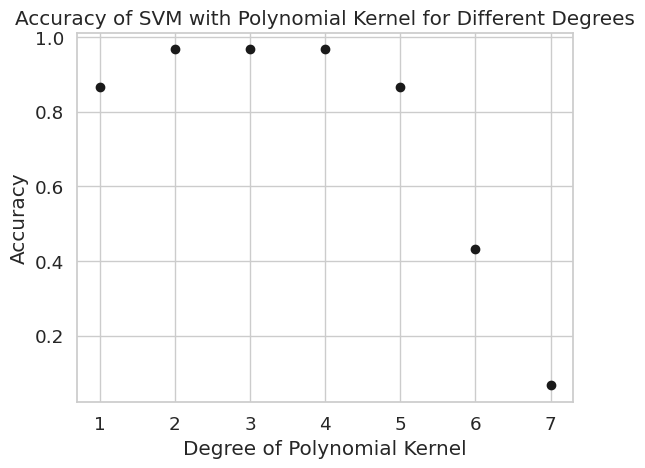

In [48]:
for i in degrees:
  # Plot the values against the custom indexes
  plt.plot(i, acc[i-1], marker='o', color='k')

plt.title('Accuracy of SVM with Polynomial Kernel for Different Degrees')
plt.xlabel('Degree of Polynomial Kernel')
plt.ylabel('Accuracy')
plt.xticks(degrees)
plt.grid(True)
plt.grid(True)
plt.show()

In [49]:
def visualize_multiclass_classification(X_train, y_train1, kernel_type, trainset, classifiers, class_labels, w_stack, b_stack,kernel_and_params,degrees):
    plt.figure(figsize=(8, 6))
    (_,poly_params, RBF_params, sigmoid_params,C) = kernel_and_params
    # Plotting data points for each class
    for i, target_name in enumerate(class_labels):
        plt.scatter(X_train[y_train1 == i, 0], X_train[y_train1 == i, 1], label=target_name)

    if kernel_type == 'linear':

        h = .02  # step size in the mesh
        x_min, x_max = X_train[:, 0].min() - 1, X_train[:, 0].max() + 1
        y_min, y_max = X_train[:, 1].min() - 1, X_train[:, 1].max() + 1
        k=np.arange(x_min, x_max, h)
        xx, yy = np.meshgrid(np.arange(x_min, x_max, h), np.arange(y_min, y_max, h))
        x_test = np.c_[xx.ravel(), yy.ravel()]
        model=multiclass_svm(x_train,x_test, y_train, C,kernel_type, poly_params, RBF_params, sigmoid_params)
        pred,_,_,_,_=model

        Z = pred.reshape(xx.shape)
        plt.contour(xx, yy, Z, cmap=plt.cm.Paired, alpha=0.8)

    else:
        h = .02  # step size in the mesh
        x_min, x_max = X_train[:, 0].min() - 1, X_train[:, 0].max() + 1
        y_min, y_max = X_train[:, 1].min() - 1, X_train[:, 1].max() + 1
        k=np.arange(x_min, x_max, h)
        xx, yy = np.meshgrid(np.arange(x_min, x_max, h), np.arange(y_min, y_max, h))
        x_test = np.c_[xx.ravel(), yy.ravel()]
        model=multiclass_svm(x_train,x_test, y_train, C,kernel_type, poly_params, RBF_params, sigmoid_params)
        pred,_,_,_,_=model

        Z = pred.reshape(xx.shape)
        plt.contour(xx, yy, Z, cmap=plt.cm.Paired, alpha=0.8)


    if trainset:
        plt.title(f'Data Points on Train Set {degrees}')
    else:
        plt.title(f'Data Points on Test Set {degrees}')

    plt.xlabel('Principal Component 1')
    plt.ylabel('Principal Component 2')
    plt.legend()
    plt.xlim(np.min(X_train[:, 0]) - 1, np.max(X_train[:, 0]) + 1)
    plt.ylim(np.min(X_train[:, 1]) - 1, np.max(X_train[:, 1]) + 1)

In [50]:
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler

#scaling and centering the data
sc = StandardScaler()
X_train_scaled = sc.fit_transform(X_train)
X_test_scaled = sc.transform(X_test)

pca = PCA (n_components=2)
X_train_pca = pca.fit_transform(X_train_scaled)
X_test_pca = pca.transform(X_test_scaled)


In [51]:
# Define the folder name
folder_name = "PCA"

# Check if the folder already exists, and create it if not
if not os.path.exists(folder_name):
    os.makedirs(folder_name)

# Commented out IPython magic to ensure Python compatibility.
%cd PCA

/content/PCA


In [52]:
degrees = range(1, 11)
acc = []
images_train = []
images_test = []
images_conf = []
# Train SVM with polynomial kernels of degree 1 to 10
for degree in degrees:
    #*****here is the callable function *****--------------------------------------------------------------
    # Split the data into training and test sets
    x_train = X_train_pca
    x_test = X_test_pca

    model=multiclass_svm(x_train,x_test, y_train, degree,'polynomial', poly_params=(1, degree), RBF_params=0.5, sigmoid_params=(1, 0.01))
    pred, kernel_and_params,w_catch, b_catch, classifiers=model

    #*****here is the callable function *****--------------------------------------------------------------
    class_0 = 0
    class_1 = 1
    class_2 = 2

    plt.figure()
    visualize_multiclass_classification(X_train_pca, y_train, kernel_and_params[0], True, classifiers, iris.target_names[class_0:class_2+2], w_catch, b_catch, kernel_and_params, degree)
    filename1 = f'svm_degree_{degree}_train_support_vector.png'
    plt.savefig(filename1)
    images_train.append(imageio.imread(filename1))
    plt.close()

    plt.figure()
    visualize_multiclass_classification(X_test_pca, y_test, kernel_and_params[0], False, classifiers, iris.target_names[class_0:class_2+2], w_catch, b_catch, kernel_and_params, degree)
    filename2 = f'svm_degree_{degree}_test_support_vector.png'
    plt.savefig(filename2)
    images_test.append(imageio.imread(filename2))
    plt.close()

    print(iris.target_names[class_0:class_2+2])

    # Evaluate the model on the training set
    if __name__ == "__main__":
        plt.figure()
        y_true = y_test
        y_pred = pred
        print(f"Degree: {degree}\n")
        acc.append(calculate_metrics_and_plot(y_true, y_pred, degree, labels=[0, 1, 2]))
        filename3 = f'svm_degree_{degree}_Confusion_Matrix.png'
        plt.savefig(filename3)
        images_conf.append(imageio.imread(filename3))
        plt.close()

# Path to save the GIF
gif_path_train = './svm_poly_degrees_train_support_vector_PCA.gif'
imageio.mimsave(gif_path_train, images_train, duration=10)
# Display the path to the GIF
print(f"GIF saved as {gif_path_train}")

# Path to save the GIF
gif_path_test = './svm_poly_degrees_test_support_vector_PCA.gif'
imageio.mimsave(gif_path_test, images_test, duration=10)
# Display the path to the GIF
print(f"GIF saved as {gif_path_test}")

# Path to save the GIF
gif_path_conf = './svm_poly_degrees_Confusion_Matrix_PCA.gif'
imageio.mimsave(gif_path_conf, images_conf, duration=10)
# Display the path to the GIF
print(f"GIF saved as {gif_path_conf}")

<ipython-input-52-3ecead7ea473>:25: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  images_train.append(imageio.imread(filename1))
<ipython-input-52-3ecead7ea473>:32: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  images_test.append(imageio.imread(filename2))


['setosa' 'versicolor' 'virginica']
Degree: 1

Class 0 - Precision: 0.7778, Recall: 1.0000, F1-score: 0.8750
Class 1 - Precision: 1.0000, Recall: 0.5000, F1-score: 0.6667
Class 2 - Precision: 0.7143, Recall: 0.8333, F1-score: 0.7692
Accuracy: 0.8000


<ipython-input-52-3ecead7ea473>:46: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  images_conf.append(imageio.imread(filename3))
<ipython-input-52-3ecead7ea473>:25: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  images_train.append(imageio.imread(filename1))
<ipython-input-52-3ecead7ea473>:32: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  images_test.append(imageio.imread(filename2))


['setosa' 'versicolor' 'virginica']
Degree: 2

Class 0 - Precision: 1.0000, Recall: 1.0000, F1-score: 1.0000
Class 1 - Precision: 0.8571, Recall: 0.6000, F1-score: 0.7059
Class 2 - Precision: 0.5556, Recall: 0.8333, F1-score: 0.6667
Accuracy: 0.8333


<ipython-input-52-3ecead7ea473>:46: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  images_conf.append(imageio.imread(filename3))
<ipython-input-52-3ecead7ea473>:25: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  images_train.append(imageio.imread(filename1))
<ipython-input-52-3ecead7ea473>:32: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  images_test.append(imageio.imread(filename2))


['setosa' 'versicolor' 'virginica']
Degree: 3

Class 0 - Precision: 1.0000, Recall: 1.0000, F1-score: 1.0000
Class 1 - Precision: 0.8571, Recall: 0.6000, F1-score: 0.7059
Class 2 - Precision: 0.5556, Recall: 0.8333, F1-score: 0.6667
Accuracy: 0.8333


<ipython-input-52-3ecead7ea473>:46: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  images_conf.append(imageio.imread(filename3))
<ipython-input-52-3ecead7ea473>:25: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  images_train.append(imageio.imread(filename1))
<ipython-input-52-3ecead7ea473>:32: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  images_test.append(imageio.imread(filename2))


['setosa' 'versicolor' 'virginica']
Degree: 4

Class 0 - Precision: 1.0000, Recall: 1.0000, F1-score: 1.0000
Class 1 - Precision: 0.8571, Recall: 0.6000, F1-score: 0.7059
Class 2 - Precision: 0.5556, Recall: 0.8333, F1-score: 0.6667
Accuracy: 0.8333


<ipython-input-52-3ecead7ea473>:46: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  images_conf.append(imageio.imread(filename3))
<ipython-input-52-3ecead7ea473>:25: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  images_train.append(imageio.imread(filename1))
<ipython-input-52-3ecead7ea473>:32: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  images_test.append(imageio.imread(filename2))


['setosa' 'versicolor' 'virginica']
Degree: 5

Class 0 - Precision: 1.0000, Recall: 1.0000, F1-score: 1.0000
Class 1 - Precision: 0.7778, Recall: 0.7000, F1-score: 0.7368
Class 2 - Precision: 0.5714, Recall: 0.6667, F1-score: 0.6154
Accuracy: 0.8333


<ipython-input-52-3ecead7ea473>:46: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  images_conf.append(imageio.imread(filename3))
<ipython-input-52-3ecead7ea473>:25: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  images_train.append(imageio.imread(filename1))
<ipython-input-52-3ecead7ea473>:32: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  images_test.append(imageio.imread(filename2))


['setosa' 'versicolor' 'virginica']
Degree: 6

Class 0 - Precision: 1.0000, Recall: 1.0000, F1-score: 1.0000
Class 1 - Precision: 0.7778, Recall: 0.7000, F1-score: 0.7368
Class 2 - Precision: 0.5714, Recall: 0.6667, F1-score: 0.6154
Accuracy: 0.8333


<ipython-input-52-3ecead7ea473>:46: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  images_conf.append(imageio.imread(filename3))
<ipython-input-52-3ecead7ea473>:25: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  images_train.append(imageio.imread(filename1))
<ipython-input-49-fd570147bdbb>:2: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`). Consider using `matplotlib.py

['setosa' 'versicolor' 'virginica']
Degree: 7

Class 0 - Precision: 0.9333, Recall: 1.0000, F1-score: 0.9655
Class 1 - Precision: 1.0000, Recall: 0.7000, F1-score: 0.8235
Class 2 - Precision: 0.6250, Recall: 0.8333, F1-score: 0.7143
Accuracy: 0.8667


<ipython-input-52-3ecead7ea473>:46: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  images_conf.append(imageio.imread(filename3))


No support vectors found
No support vectors found


<ipython-input-52-3ecead7ea473>:25: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  images_train.append(imageio.imread(filename1))


No support vectors found


<ipython-input-52-3ecead7ea473>:32: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  images_test.append(imageio.imread(filename2))


['setosa' 'versicolor' 'virginica']
Degree: 8

Class 0 - Precision: 1.0000, Recall: 0.0714, F1-score: 0.1333
Class 1 - Precision: 0.7778, Recall: 0.7000, F1-score: 0.7368
Class 2 - Precision: 0.2000, Recall: 0.6667, F1-score: 0.3077
Accuracy: 0.4000


<ipython-input-52-3ecead7ea473>:46: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  images_conf.append(imageio.imread(filename3))


No support vectors found
No support vectors found


<ipython-input-52-3ecead7ea473>:25: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  images_train.append(imageio.imread(filename1))


No support vectors found


<ipython-input-52-3ecead7ea473>:32: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  images_test.append(imageio.imread(filename2))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


['setosa' 'versicolor' 'virginica']
Degree: 9

Class 0 - Precision: 0.0000, Recall: 0.0000, F1-score: 0.0000
Class 1 - Precision: 0.3043, Recall: 0.7000, F1-score: 0.4242
Class 2 - Precision: 0.5714, Recall: 0.6667, F1-score: 0.6154
Accuracy: 0.3667


<ipython-input-52-3ecead7ea473>:46: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  images_conf.append(imageio.imread(filename3))


No support vectors found
No support vectors found


<ipython-input-52-3ecead7ea473>:25: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  images_train.append(imageio.imread(filename1))


No support vectors found


<ipython-input-52-3ecead7ea473>:32: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  images_test.append(imageio.imread(filename2))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


['setosa' 'versicolor' 'virginica']
Degree: 10

Class 0 - Precision: 0.0000, Recall: 0.0000, F1-score: 0.0000
Class 1 - Precision: 0.7273, Recall: 0.8000, F1-score: 0.7619
Class 2 - Precision: 0.2105, Recall: 0.6667, F1-score: 0.3200
Accuracy: 0.4000


<ipython-input-52-3ecead7ea473>:46: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  images_conf.append(imageio.imread(filename3))


GIF saved as ./svm_poly_degrees_train_support_vector_PCA.gif
GIF saved as ./svm_poly_degrees_test_support_vector_PCA.gif
GIF saved as ./svm_poly_degrees_Confusion_Matrix_PCA.gif


<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

In [53]:
%cd ..


/content


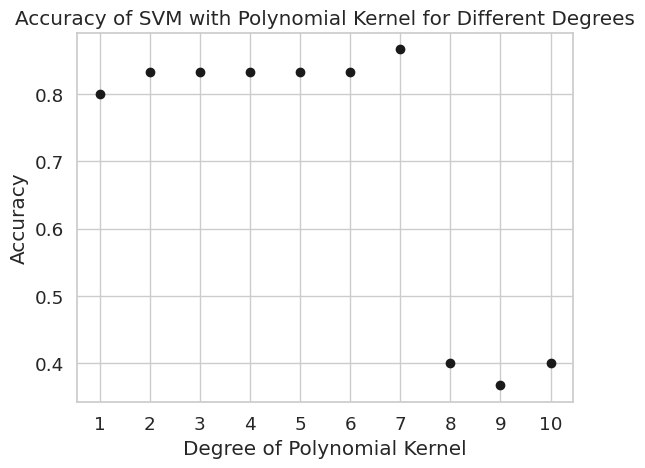

In [54]:
for i in degrees:
  # Plot the values against the custom indexes
  plt.plot(i, acc[i-1], marker='o', color='k')

plt.title('Accuracy of SVM with Polynomial Kernel for Different Degrees')
plt.xlabel('Degree of Polynomial Kernel')
plt.ylabel('Accuracy')
plt.xticks(degrees)
plt.grid(True)
plt.grid(True)
plt.show()